In [1]:
# conda install theano; at time of writing, need to downgrade numpy version to 1.15 (conda install numpy=1.15)

In [3]:
# config theano to use GPU, must be done before theano is imported
import os    
os.environ['THEANO_FLAGS'] = "device=cuda,mode=FAST_RUN,floatX=float32"    

In [4]:
import numpy as np
import theano
from theano import tensor as T

In [15]:
np.array([1,2,3])

array([1, 2, 3])

In [16]:
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

net_input(2.0, 1.0, 0.5)

array(2.5, dtype=float32)

In [17]:
# initialize variables, compile fuction, execute function

x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

calc_sum = theano.function(inputs=[x], outputs=x_sum)

# execute (Python list)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

 # execute (NumPy array)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [2. 4. 6.]
Column sum: [2. 4. 6.]


In [18]:
# updating variable per execution: 
# every time the function is called, the updates variables(i.e. w) gets updated at the end of the execution

x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

net_input = theano.function(
  inputs=[x],
  updates=update, # update target must be a SharedVariable
  outputs=z
)

data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[0.]]
z1: [[6.]]
z2: [[12.]]
z3: [[18.]]
z4: [[24.]]


In [19]:
# same code as above, 
# except instead of passing :data into :inputs (where memory is transferred from CPU to GPU every iteration)
# :data is included in :givens, allowing memory to stay in GPU
x = T.fmatrix('var_x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

net_input = theano.function(
  inputs=[],
  updates=update, # update target must be a SharedVariable
  givens ={x: data}, # givens is a dict that maps variable name to an actual object
  outputs=z
)

data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input())

z0: [[0.]]
z1: [[6.]]
z2: [[12.]]
z3: [[18.]]
z4: [[24.]]


In [20]:
# note: setting dtype when creating array so that code would accomodate when theano floatX changes
X_train = np.asarray(
    [
        [0.0], 
        [1.0],
        [2.0],
        [3.0],
        [4.0],
        [5.0],
        [6.0],
        [7.0],
        [8.0],
        [9.0]
    ],
    dtype = theano.config.floatX
)
y_train = np.asarray(
    [
        1.0,
        1.3,
        3.1,
        2.0,
        5.0,
        6.3,
        6.6,
        7.4,
        8.0,
        9.0
    ],
    dtype = theano.config.floatX
)

In [21]:
def train_linreg(X_train, y_train, eta, epochs):
    costs = []
    eta0 = T.fscalar('eta0')
    y = T.fvector(name = 'y')
    X = T.fmatrix(name = 'X')
    w = theano.shared(
            np.zeros(
                shape=(X_train.shape[1] + 1), 
                dtype = theano.config.floatX
            ), 
            name = 'w'
        )
    
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2)) # sum of square diff/ordinary least squares
    
    gradient = T.grad(cost, wrt=w) # automatically calc d(sigma(y^2))/dw
    update = [
        [w, w - eta0 * gradient]
    ]
    
    train = theano.function(
        inputs=[eta0],
        outputs=cost,
        updates=update,
        givens = {
            X: X_train,
            y: y_train
        }
    )
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

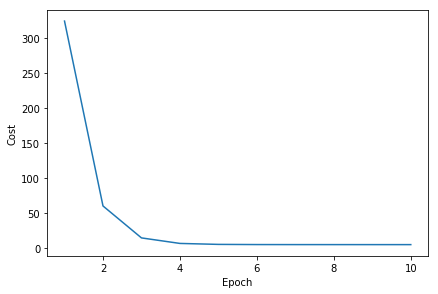

In [22]:
import matplotlib.pyplot as plt

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [23]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt],
                             givens={w: w},
                             outputs=net_input)
    return predict(X)

Text(0, 0.5, 'y')

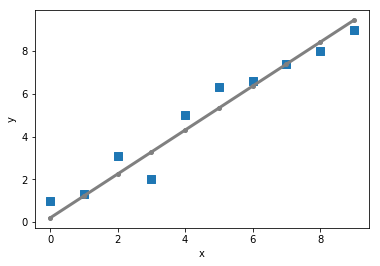

In [24]:
plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(
    range(X_train.shape[0]), 
    predict_linreg(X_train, w),
    color='gray',
    marker='o',
    markersize=4,
    linewidth=3
)
plt.xlabel('x')
plt.ylabel('y')

In [5]:
# from ch12, same
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import struct

def load_mnist(path, kind='train'):
    labels_path = '{}-labels-idx1-ubyte'.format(kind)
    images_path = '{}-images-idx3-ubyte'.format(kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784) # 784=28x28 pixel images
    return images, labels

X_train, y_train = load_mnist('.', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [6]:
from keras.utils import np_utils

X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)
print('First 3 labels: ', y_train[:3])
y_train_ohe = np_utils.to_categorical(y_train)
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [7]:
X_train.shape

(60000, 784)

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

model = Sequential() # feed forward network
# 3 layers network
# Note on actiation used
# tanh - similar to sigmoid functio but ranges from -1 to 1, thus likely to fasten convergence
# softmax - divide prob result by sum of probs so that the result sums up to 1, i.e predict_proba

# first layer (784, 50)
model.add(
    Dense(
        50, #output units
        input_dim=X_train.shape[1],
        kernel_initializer='uniform',
        activation='tanh'
    )
)
# second layer (50, 50)
model.add(
    Dense(
        50,
        input_dim=50,
        kernel_initializer='uniform',
        activation='tanh'
    )
)
# output layer (50, 10)
model.add(
    Dense(
        y_train_ohe.shape[1],
        input_dim=50,
        kernel_initializer='uniform',
        activation='softmax'
    )
)
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)# (mini-batch) stochastic gradient descent, SGD
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])# crossentropy=cost function of log regression; categorical_crossentropy=cost for multi-class result

In [9]:
model.fit(
  X_train,
  y_train_ohe,
  epochs=50,
  batch_size=300,
  verbose=1,
  validation_split=0.1,
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 37us/step - loss: 2.2207 - acc: 0.4292 - val_loss: 2.0862 - val_acc: 0.6278
Epoch 2/50
54000/54000 [==============================] - 1s 20us/step - loss: 1.8302 - acc: 0.6197 - val_loss: 1.5070 - val_acc: 0.6513
Epoch 3/50
54000/54000 [==============================] - 1s 26us/step - loss: 1.2998 - acc: 0.6581 - val_loss: 1.0754 - val_acc: 0.7245
Epoch 4/50
54000/54000 [==============================] - 1s 26us/step - loss: 0.9820 - acc: 0.7484 - val_loss: 0.8198 - val_acc: 0.8088
Epoch 5/50
54000/54000 [==============================] - 1s 20us/step - loss: 0.7790 - acc: 0.8072 - val_loss: 0.6519 - val_acc: 0.8612
Epoch 6/50
54000/54000 [==============================] - 1s 27us/step - loss: 0.6452 - acc: 0.8505 - val_loss: 0.5466 - val_acc: 0.8868
Epoch 7/50
54000/54000 [==============================] - 2s 28us/step - loss: 0.5569 - acc: 0.8686 - val_loss: 0.4685 - val_acc:

In [10]:
y_train_pred = model.predict_classes(X_train, verbose=0)

In [11]:
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [12]:
train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

Training accuracy: 94.26%


In [13]:
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

Test accuracy: 93.76%
